In [ ]:
import numpy as np
from scipy.io import loadmat

# importing mat files

In [ ]:

mat1 = loadmat('ForceVec.mat')

In [ ]:
mat1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'B'])

In [ ]:
mat1.items()

dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar  8 16:37:11 2022'), ('__version__', '1.0'), ('__globals__', []), ('B', array([[ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [375.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [117.32584878],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [231.76274578],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.

In [ ]:
mat1['B'].shape

(100, 1)

In [ ]:
mat2 = loadmat('Stiffness.mat')

In [ ]:

mat2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'K'])

In [ ]:
mat2.items()

dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar  8 16:36:32 2022'), ('__version__', '1.0'), ('__globals__', []), ('K', array([[ 1.08333333, -0.33333333,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.33333333,  2.16666667, -0.33333333, ...,  0.        ,
         0.        , -1.5       ],
       [ 0.        , -0.33333333,  2.16666667, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  4.33333333,
        -1.5       ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.5       ,
         4.33333333, -1.5       ],
       [ 0.        , -1.5       ,  0.        , ...,  0.        ,
        -1.5       ,  4.33333333]]))])

In [ ]:
mat2['K'].shape

(100, 100)

In [ ]:
type(mat2['K'])

numpy.ndarray

In [ ]:
ForceVec = mat1['B']
stiffness = mat2['K']

In [ ]:
print(type(ForceVec),type(stiffness))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Steepest_descent


In [ ]:
def steepest_descent(A,b,x):

    if (np.all(np.linalg.eigvals(A) > 0) == False) | (A != A.T).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    residual = b - A @ x
    num_iter = 0
    residual_norm_init = (residual.T @ residual)
    residual_norm_curr = residual_norm_init
    epsilon = 1e-10
    while (residual_norm_curr > (epsilon)*residual_norm_init):

        temp = A @ residual
        alpha = residual_norm_curr/(residual.T @ temp)
        x = x + (alpha * residual)

        if num_iter%10 == 0:
            residual = b - A @ x

        else:
            residual = residual - (alpha * temp)

        residual_norm_curr = (residual.T @ residual)
        num_iter += 1

    # print(np.linalg.norm(residual))
    return x,num_iter

In [ ]:
%%time
inverse_matrix = np.linalg.inv(stiffness) @ ForceVec

CPU times: user 811 µs, sys: 5.09 ms, total: 5.9 ms
Wall time: 9.91 ms


In [ ]:
%%time
starting_x = np.random.random((100,1))
x,k = steepest_descent(stiffness,ForceVec,starting_x)

CPU times: user 30.1 ms, sys: 44.7 ms, total: 74.7 ms
Wall time: 62.2 ms


In [ ]:
k

878

In [ ]:
np.linalg.norm(x - inverse_matrix)

0.2667130937003342

# complexity of steepest descent

In [ ]:
lambda_max = max(np.linalg.eigvals(stiffness))
lambda_min = min(np.linalg.eigvals(stiffness))
print(lambda_max,lambda_min)

8.46616168907499 0.04364848232914995


In [ ]:
spectral_radius = lambda_max

In [ ]:
condition_number = abs(lambda_max/lambda_min)
print(condition_number)

193.96233814574114


In [ ]:
import math
omega_max = (k-1)/(k+1)
print(omega_max)

0.9977246871444824


In [ ]:
epsilon = 1e-10
steepest_max_iter = math.log(1/(epsilon))/math.log((condition_number+1)/(condition_number-1))

In [ ]:
steepest_max_iter

2233.054156443121

$O(max(sparsity,n)*steepest\_max\_iter) = O(n*steepest\_max\_iter)$

$steepest\_max\_iter = \frac{ln(1/ϵ)}{ln\big(\frac{κ+1}{κ-1}\big)}$

$κ = \frac{λ_{max}}{λ_{min}}$

# Conjugate_gradient

In [ ]:
def conjugate_gradient(A,b,x,n):

    if (np.all(np.linalg.eigvals(A) > 0) == False | (A != A.T).any()):
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    r = b- A @ x
    d = r
    num_iter = 0
    residual_norm_init = (r.T @ r)
    residual_norm_curr = residual_norm_init
    epsilon = 1e-10

    while (residual_norm_curr > (epsilon)*residual_norm_init and num_iter < n):

        p = A @ d
        alpha = residual_norm_curr/(d.T @ p)
        x = x + alpha * d
        if num_iter%10 == 0:
            r = b - A @ x
        else:
            r = r - alpha * p
        temp = residual_norm_curr
        residual_norm_curr = r.T @ r
        beta = residual_norm_curr/temp
        d = r + beta * d
        num_iter = num_iter + 1

    return x,num_iter

In [ ]:
%%time
inverse_matrix = np.linalg.inv(stiffness) @ ForceVec

CPU times: user 1.25 ms, sys: 55 µs, total: 1.3 ms
Wall time: 1.62 ms


In [ ]:
%%time
# x = np.zeros((100,1))
x,num_iter = conjugate_gradient(stiffness,ForceVec,starting_x,100)

CPU times: user 6.63 ms, sys: 7 ms, total: 13.6 ms
Wall time: 14 ms


In [ ]:
num_iter

41

In [ ]:
np.linalg.norm(x - inverse_matrix)

0.0040543865584149455

# complexity of conjugate gradient

In [ ]:
epsilon = 1e-10
temp = math.sqrt(condition_number)
conjugate_max_iter = math.log(2/(epsilon))/math.log((temp+1)/(temp-1))

In [ ]:
conjugate_max_iter

164.88343334982065

In [ ]:
omega = ((temp-1)/(temp+1))

In [ ]:
omega

0.8660149296074415

$O(max(sparsity,n)*conjugate\_max\_iter) = O(n*conjugate\_max\_iter)$

$conjugate\_max\_iter = min\Big(\frac{ln(2/ϵ)}{ln\big(\frac{\sqrt{k}+1}{\sqrt{k} -1}\big)},n \Big)$

$κ = \frac{λ_{max}}{λ_{min}}$

# Comparing steepest descent and conjugate gradient

In [ ]:
def comp_steepest_descent(A,b,x,epsilon = 1e-10):

    if (np.all(np.linalg.eigvals(A) > 0) == False) | (A != A.T).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    residual = b - A @ x
    num_iter = 0
    residual_norm_init = (residual.T @ residual)
    residual_norm_curr = residual_norm_init
    ls = []
    k = []
    while (residual_norm_curr > (epsilon)*residual_norm_init):
        temp = A @ residual
        alpha = residual_norm_curr/(residual.T @ temp)
        x = x + (alpha * residual)

        if num_iter%10 == 0:
            residual = b - A @ x
            ls.append(x)
            k.append(num_iter)

        else:
            residual = residual - (alpha * temp)

        residual_norm_curr = (residual.T @ residual)
        num_iter += 1

    ls = np.asarray(ls)
    # print(np.linalg.norm(residual))
    return x,num_iter,ls,k


def comp_conjugate_gradient(A,b,x,n,epsilon = 1e-10):

    if (np.all(np.linalg.eigvals(A) > 0) == False | (A != A.T).any()):
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    r = b- A @ x
    d = r
    num_iter = 0
    residual_norm_init = (r.T @ r)
    residual_norm_curr = residual_norm_init
    ls = []
    k = []
    while (residual_norm_curr > (epsilon)*residual_norm_init and num_iter < n):
        p = A @ d
        alpha = residual_norm_curr/(d.T @ p)
        x = x + alpha * d
        if num_iter%10 == 0:
            r = b - A @ x
            ls.append(x)
            k.append(num_iter)
        else:
            r = r - alpha * p
        temp = residual_norm_curr
        residual_norm_curr = r.T @ r
        beta = residual_norm_curr/temp
        d = r + beta * d
        num_iter = num_iter + 1

    ls = np.asarray(ls)
    return x,num_iter,ls,k

def norm_calculator(curr_x,x):
    return np.linalg.norm(curr_x - x)

In [ ]:
# %%time
inverse = np.linalg.inv(stiffness) @ ForceVec

In [ ]:
x = np.random.random((100,1))

In [ ]:
%%time
x_steepest,steepest_iter,arr1,k_steep = comp_steepest_descent(stiffness,ForceVec,x)
steepest_norms = []
for i in range(len(arr1)):
    steepest_norms.append(norm_calculator(arr1[i],inverse))

x_conjugate,conjugate_iter,arr2,k_conjugate = comp_conjugate_gradient(stiffness,ForceVec,x,100)
conjugate_norms=[]
for i in range(len(arr2)):
    conjugate_norms.append(norm_calculator(arr2[i],inverse))

final_steepest_norm = norm_calculator(x_steepest,inverse)
final_conjugate_norm = norm_calculator(x_conjugate,inverse)

CPU times: user 42.5 ms, sys: 31.1 ms, total: 73.6 ms
Wall time: 47.4 ms


In [ ]:
print(f'Norm difference of final solution obtained by steepest_descent after {steepest_iter} iterations is {final_steepest_norm}')
print(f'Norm difference of final solution obtained by conjugate_gradient after {conjugate_iter} iterations is {final_conjugate_norm}')

Norm difference of final solution obtained by steepest_descent after 878 iterations is 0.2664364428918653
Norm difference of final solution obtained by conjugate_gradient after 41 iterations is 0.004092750459702243


In [ ]:
num_iter = [0,10,20,30,40]

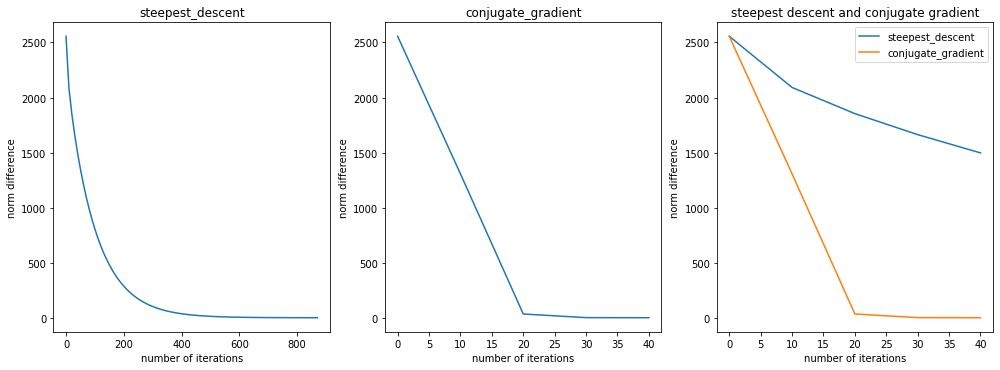

In [ ]:
import matplotlib.pyplot as plt
figure, axis = plt.subplots(1,3)
axis[0].plot(k_steep,steepest_norms)
axis[0].set_title("steepest_descent")
axis[1].plot(k_conjugate,conjugate_norms)
axis[1].set_title('conjugate_gradient')
axis[2].plot(num_iter,steepest_norms[:len(num_iter)])
axis[2].plot(num_iter,conjugate_norms)
axis[2].legend(['steepest_descent','conjugate_gradient'],loc = "upper right")
axis[2].set_title("steepest descent and conjugate gradient")
# figure.subplots_adjust(hspace=10,wspace = 0.01)
plt.subplots_adjust(top = 1.2,right = 2.3)
plt.setp(axis,xlabel = 'number of iterations')
plt.setp(axis,ylabel = 'norm difference')
plt.show()


# Gibbs Sampling

In [ ]:
import random
import math
import numpy as np
from numpy.linalg import eig

In [ ]:
def normal(mean,var):
    return mean +  math.sqrt(var) * float(np.random.randn(1))

In [ ]:
def gibbs_sampling(N,num_iter = 1000,start = np.zeros(100)):
    iter = num_iter
    x = np.zeros((iter*N,N))
    for j in range(iter):
        for i in range(N):
            temp = np.delete(start,[i],None)
            var = 1/A[i][i]
            intermediate = (np.delete(A[i],[i],None)/(-A[i][i]))
            mean = intermediate @ temp.T
            start[i] = normal(mean,var)
            x[j*N+i] = start
    return x

def summation(N,x,sigma,samples,num_iter = 100,start = np.zeros(100)):
    sum = np.zeros((N,N))
    count = 0
    visited = 0
    if samples == 0:
        sum = sum + np.outer(start,start.T)
        return np.linalg.norm(sum-sigma)
    
    for j in range(num_iter):
        for i in range(N):
            sum = sum  + np.outer(x[j*N+i],x[j*N+i].T)/(samples)
            count += 1
            if count == samples:
                visited = 1
                break
        if visited == 1:
            break
    dist = np.linalg.norm(sum - sigma)
    return dist

def matrixnorm(N,x,A,sigma,samples,num_iter = 100):
    val = np.zeros((N,N))
    count = 0
    for j in range(num_iter):
            val = val  + np.outer(x[j*N],x[j*N].T)/(x[j*N][None,:] @ A @ x[j*N][:,None])
            count += 1
            if count == samples:
                break
    val = (val/samples)*N
    dist = np.linalg.norm(val - sigma)
    return dist

def new_summation(N,x,sigma,samples,num_iter = 100):
    new_sum = np.zeros((N,N))
    burn_in = N//10
    count = 0
    for j in range(burn_in,num_iter):
        new_sum = new_sum + np.outer(x[j*N],x[j*N].T)/samples
        count += 1
        if count == samples:
            break
    # new_sum = (new_sum/samples)*N
    dist = np.linalg.norm(new_sum - sigma)
    return dist


In [ ]:
N = 100
A = stiffness
sigma = np.linalg.inv(A)

In [ ]:
np.count_nonzero(A)

460

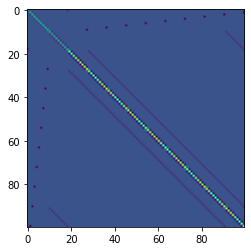

In [ ]:
imgplt = plt.imshow(A)

In [ ]:
if __name__ == "__main__":
    
    num_iter = 1000
    new_iter = 1000
    start = np.zeros(N)
    x = gibbs_sampling(N,num_iter,start)
    norm = summation(N,x,sigma,num_iter*N,num_iter)
    print(f'Plane Gibbs sampling norm = {norm}')

    new_norm = new_summation(N,x,sigma,new_iter)
    print(f'Gibbs sampling norm with N samples = {new_norm}')

    conjugate_norm = matrixnorm(N,x,A,sigma,new_iter)
    print(f'conjugate norm with N samples = {conjugate_norm}')

Plane Gibbs sampling norm = 14.390980688034107
Gibbs sampling norm with N samples = 24.18595774726838
conjugate norm with N samples = 24.027142346358495


In [ ]:
plane_gibbs_sampler_norm = []
plane_sampler_num_samp = []
for i in range(0,num_iter+1,100):
    plane_gibbs_sampler_norm.append(summation(N,x,sigma,i*N,num_iter))
    plane_sampler_num_samp.append(i*N)

In [ ]:
plane_gs_norm_mat = []
for j in range(10):
    plane_gs_norm = []
    x = gibbs_sampling(N,num_iter,start)
    for i in range(0,num_iter+1,100):
        plane_gs_norm.append(summation(N,x,sigma,i*N,num_iter))
    plane_gs_norm_mat.append(plane_gs_norm)
plane_gs_norm_mat = np.array(plane_gs_norm_mat)
avg_plane_gs_norm = np.mean(plane_gs_norm_mat,axis = 0)

In [ ]:
N_samples_gibbs_sampler_norm = []
N_sample_num_samp = []
for i in range(1,new_iter+1,100):
    N_samples_gibbs_sampler_norm.append(new_summation(N,x,sigma,i,new_iter))
    N_sample_num_samp.append(i)

In [ ]:
N_samples_gs_norm_mat = []
for j in range(10):
    N_samples_gs_norm = []
    x = gibbs_sampling(N,new_iter,start)
    for i in range(1,new_iter+1,100):
        N_samples_gs_norm.append(new_summation(N,x,sigma,i,new_iter))
    N_samples_gs_norm_mat.append(N_samples_gs_norm)
avg_N_samples_gs_norm = np.mean(np.array(N_samples_gs_norm_mat),axis=0)

In [ ]:
conjugate_gibbs_sampler_norm = []
conjugate_gibbs_samp = []
for i in range(1,new_iter+1,100):
    conjugate_gibbs_sampler_norm.append(matrixnorm(N,x,A,sigma,i,num_iter))
    conjugate_gibbs_samp.append(i)

In [ ]:
conjugate_gs_norm_mat = []
for j in range(10):
    conjugate_gs_norm = []
    x = gibbs_sampling(N,new_iter)
    for i in range(1,new_iter+1,100):
        conjugate_gs_norm.append(matrixnorm(N,x,A,sigma,i,new_iter))
    conjugate_gs_norm_mat.append(conjugate_gs_norm)
avg_conjugate_gs_norm = np.mean(np.array(conjugate_gs_norm_mat),axis=0)

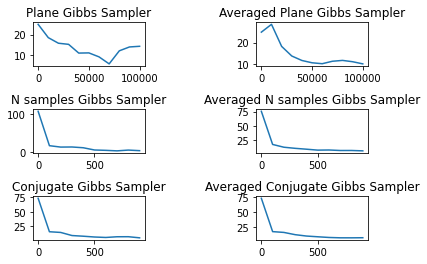

In [ ]:
import matplotlib.pyplot as plt
figure, axis = plt.subplots(3, 2)
axis[0, 0].plot(plane_sampler_num_samp,plane_gibbs_sampler_norm)
axis[0, 0].set_title("Plane Gibbs Sampler")
axis[0,1].plot(plane_sampler_num_samp,avg_plane_gs_norm)
axis[0,1].set_title('Averaged Plane Gibbs Sampler')
axis[1, 0].plot(N_sample_num_samp,N_samples_gibbs_sampler_norm)
axis[1, 0].set_title("N samples Gibbs Sampler")
axis[1, 1].plot(N_sample_num_samp,avg_N_samples_gs_norm)
axis[1, 1].set_title("Averaged N samples Gibbs Sampler")
axis[2, 0].plot(conjugate_gibbs_samp,conjugate_gibbs_sampler_norm)
axis[2, 0].set_title("Conjugate Gibbs Sampler")
axis[2, 1].plot(conjugate_gibbs_samp,avg_conjugate_gs_norm)
axis[2, 1].set_title("Averaged Conjugate Gibbs Sampler")
figure.subplots_adjust(hspace=1, wspace=1)
plt.show()

In [ ]:
print(f'Plane Gibbs sampler averaged norm = {avg_plane_gs_norm[-1]}')

Plane Gibbs sampler averaged norm = 9.922103582220446


In [ ]:
print(f'averaged Gibbs sampling norm with N samples = {avg_N_samples_gs_norm[-1]}')

averaged Gibbs sampling norm with N samples = 6.071085294706805


In [ ]:
print(f'averaged conjugate norm = {avg_conjugate_gs_norm[-1]}')

averaged conjugate norm = 7.620766674907076


# Solution using Gibbs Sampling


In [ ]:
import random
import math
import numpy as np
from numpy.linalg import eig

In [ ]:
def normal(mean,var):
    return mean +  math.sqrt(var) * float(np.random.randn(1))

In [ ]:
def gibbs_sampling(N,num_iter = 1000,start = np.zeros(100)):
    iter = num_iter
    x = np.zeros((iter*N,N))
    for j in range(iter):
        for i in range(N):
            temp = np.delete(start,[i],None)
            var = 1/A[i][i]
            intermediate = (np.delete(A[i],[i],None)/(-A[i][i]))
            mean = intermediate @ temp.T
            start[i] = normal(mean,var)
            x[j*N+i] = start
    return x

def many_samples_solution(N,x,b,actual_sol,sigma,samples,num_iter = 100,start = np.zeros(100)):
    sum = np.zeros((N,N))
    count = 0
    visited = 0
    if samples == 0:
        sum = sum + np.outer(start,start.T)
        return np.linalg.norm(sum-sigma)
    
    for j in range(num_iter):
        for i in range(N):
            sum = sum  + np.outer(x[j*N+i],x[j*N+i].T)/(samples)
            count += 1
            if count == samples:
                visited = 1
                break
        if visited == 1:
            break
    
    final_sol = sum @ b
    dist = np.linalg.norm(final_sol - actual_sol)
    print(np.linalg.norm(sum-sigma))

    return dist

def conjugate_solution(N,x,A,b,actual_sol,sigma,samples,num_iter = 100):
    val = np.zeros((N,N))
    count = 0
    for j in range(num_iter):
            val = val  + np.outer(x[j*N],x[j*N].T)/(x[j*N][None,:] @ A @ x[j*N][:,None])
            count += 1
            if count == samples:
                break
    val = (val/samples)*N
    final_sol = val @ b
    print(np.linalg.norm(val - sigma))
    dist = np.linalg.norm(final_sol - actual_sol)
    return dist

def few_samples_solution(N,x,b,actual_sol,sigma,samples,num_iter = 100):
    new_sum = np.zeros((N,N))
    burn_in = N//10
    count = 0
    for j in range(burn_in,num_iter):
        new_sum = new_sum + np.outer(x[j*N],x[j*N].T)/samples
        count += 1
        if count == samples:
            break
    final_sol = new_sum @ b 
    print(np.linalg.norm(new_sum - sigma))
    dist = np.linalg.norm(final_sol - actual_sol)
    return dist

# def new_conjugate_solution(N,x,A,b,p,actual_sol,sigma,samples,num_iter = 100):
#     val = np.zeros(N)
#     count = 0
#     for j in range(num_iter):
#             r = b - A @ x[j*N]
#             val = val  + np.dot(x[j*N].T,r)/(x[j*N].T @ A @ x[j*N]) * x[j*N]
#             count += 1
#             if count == samples:
#                 break
#     val = (val/samples)*N
#     # print(np.linalg.norm(val - sigma))
#     dist = np.linalg.norm(val - actual_sol)
#     return dist


In [ ]:
N = 100
A = stiffness
b = ForceVec
sigma = np.linalg.inv(A)

In [ ]:
max(b)

array([740.76625545])

In [ ]:
min(b)

array([-0.])

In [ ]:
actual_sol = sigma @ b

In [ ]:
# for i in range(N):
#     new_conjugate_norm = new_conjugate_solution(N,x,A,b,i,actual_sol,sigma,new_iter)
#     print(f'Norm of Final Solution obtained by Conjugate Gibbs Sampler wrt actual solution with p as {i} = {new_conjugate_norm}')

In [ ]:
if __name__ == "__main__":
    
    num_iter = 1000
    new_iter = 1000
    start = np.zeros(N)
    x = gibbs_sampling(N,num_iter,start)

    norm = many_samples_solution(N,x,b,actual_sol,sigma,num_iter*N,num_iter)
    print(f'Norm of Final Solution obtained by Plane Gibbs Sampler wrt actual solution = {norm}')

    conjugate_norm = conjugate_solution(N,x,A,b,actual_sol,sigma,new_iter)
    print(f'Norm of Final Solution obtained by Conjugate Gibbs Sampler wrt actual solution = {conjugate_norm}')

    N_sampler_norm = few_samples_solution(N,x,b,actual_sol,sigma,new_iter)
    print(f'Norm of Final Solution obtained by {new_iter} samples Gibbs Sampler wrt actual solution = {N_sampler_norm}')


5.448948364657716
Norm of Final Solution obtained by Plane Gibbs Sampler wrt actual solution = 836.4121169055041
18.94745538268126
Norm of Final Solution obtained by Conjugate Gibbs Sampler wrt actual solution = 2254.2952773957013
18.811524243510796
Norm of Final Solution obtained by 1000 samples Gibbs Sampler wrt actual solution = 2243.2338237569184


In [ ]:
def gibbs_sampling(N,num_iter = 1000,start = np.zeros(100)):
    iter = num_iter
    x = np.zeros((iter*N,N))
    for j in range(iter):
        for i in range(N):
            temp = np.delete(start,[i],None)
            var = 1/A[i][i]
            intermediate = (np.delete(A[i],[i],None)/(-A[i][i]))
            mean = intermediate @ temp.T
            start[i] = normal(mean,var)
            x[j*N+i] = start
    return x

def updated_many_samples_solution(N,x,b,actual_sol,sigma,samples,num_iter = 100,start = np.zeros(100)):
    sum = np.zeros(N)
    count = 0
    visited = 0
    # if samples == 0:
    #     sum = sum + np.outer(start,start.T)
    #     return np.linalg.norm(sum-sigma)
    
    for j in range(num_iter):
        for i in range(N):
            sum = sum  + (np.dot(x[j*N+i].T,b) * x[j*N+i])/(samples)
            count += 1
            if count == samples:
                visited = 1
                break
        if visited == 1:
            break
    
    final_sol = sum 
    dist = np.linalg.norm(final_sol - actual_sol)

    return dist

def updated_conjugate_solution(N,x,A,b,actual_sol,sigma,samples,num_iter = 100):
    val = np.zeros(N)
    count = 0
    for j in range(num_iter):
            val = val  + (np.dot(x[j*N].T,b) * x[j*N])/(x[j*N] @ A @ x[j*N].T)
            count += 1
            if count == samples:
                break

    val = (val/samples)*N
    final_sol = val
    dist = np.linalg.norm(final_sol - actual_sol)
    return dist

def updated_few_samples_solution(N,x,b,actual_sol,sigma,samples,num_iter = 100):
    new_sum = np.zeros(N)
    burn_in = N//10
    count = 0
    for j in range(burn_in,num_iter):
        new_sum = new_sum + (np.dot(x[j*N].T,b) * x[j*N])/samples
        count += 1
        if count == samples:
            break
    final_sol = new_sum 
    dist = np.linalg.norm(final_sol - actual_sol)
    return dist

# def new_conjugate_solution(N,x,A,b,p,actual_sol,sigma,samples,num_iter = 100):
#     val = np.zeros(N)
#     count = 0
#     for j in range(num_iter):
#             r = b - A @ x[j*N]
#             val = val  + np.dot(x[j*N].T,r)/(x[j*N].T @ A @ x[j*N]) * x[j*N]
#             count += 1
#             if count == samples:
#                 break
#     val = (val/samples)*N
#     # print(np.linalg.norm(val - sigma))
#     dist = np.linalg.norm(val - actual_sol)
#     return dist


In [ ]:
if __name__ == "__main__":
    
    num_iter = 1000
    new_iter = 1000
    start = np.zeros(N)
    x = gibbs_sampling(N,num_iter,start)

    norm = updated_many_samples_solution(N,x,b,actual_sol,sigma,num_iter*N,num_iter)
    print(f'Norm of Final Solution obtained by Plane Gibbs Sampler wrt actual solution = {norm}')

    conjugate_norm = updated_conjugate_solution(N,x,A,b,actual_sol,sigma,new_iter)
    print(f'Norm of Final Solution obtained by Conjugate Gibbs Sampler wrt actual solution = {conjugate_norm}')

    N_sampler_norm = updated_few_samples_solution(N,x,b,actual_sol,sigma,new_iter)
    print(f'Norm of Final Solution obtained by N samples Gibbs Sampler wrt actual solution = {N_sampler_norm}')


Norm of Final Solution obtained by Plane Gibbs Sampler wrt actual solution = 15909.836129562866
Norm of Final Solution obtained by Conjugate Gibbs Sampler wrt actual solution = 26195.73697763355
Norm of Final Solution obtained by N samples Gibbs Sampler wrt actual solution = 26215.887506157596


# nCr

In [ ]:
import time
import math

In [ ]:
def combinations(n,r):
    t = 1
    if n-r > r:
        for i in range(1,r+1):
            t = t * (n-r+i)/i
    else:
        for i in range(1,n-r+1):
            t = t * (r+i)/i
            if math.isinf(t) == True:
                print(i)
                return -1
    return int(t)

In [ ]:
tic = time.time()
print(combinations(2000,100))
toc = time.time()

1096061485893795846139728583784861075791647209842905529623769337184881853001847626384386497063816236643638578049048597695145108692403358909741576520736512198403209155313664


In [ ]:
toc - tic

0.0007882118225097656